### Transformers Pattern Recognition on Interactions between Orthogonal Concepts
1. the idea is to check how LLM detects and tracks causal patterns between real concepts
2. as an input we use simple lists of words which flip their "conceptual" domain each step
3. we also use more complex lists of *word pairs* thus encoding non-trivial switching behavior
4. finally we try to track detection of causal generative graphs (Hasse Diagram) between Concepts

In [17]:
from functools import partial
from typing import List, Optional, Union

import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import pandas as pd
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float
from tqdm import tqdm

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [12]:
import json
synonym_antonym_pairs = json.load(open('data/synonym_antonym_pairs.json'))

In [15]:
synonym_antonym_pairs['synonyms_antonyms_en'][:4]

[[['male', 'man'], ['male', 'female']],
 [['alive', 'living'], ['dead', 'alive']],
 [['positive', 'affirmative'], ['positive', 'negative']],
 [['on', 'activated'], ['on', 'off']]]

In [16]:
synonym_antonym_pairs['synonyms_antonyms_fr'][:4]

[[['mâle', 'homme'], ['mâle', 'femelle']],
 [['vivant', 'en vie'], ['mort', 'vivant']],
 [['positif', 'affirmatif'], ['positif', 'négatif']],
 [['activé', 'en marche'], ['allumé', 'éteint']]]

In [18]:
from collections import Counter
def generate_string_from_patterns(syn_ant_lan1, syn_ant_lan2, connector_pattern, language_pattern, synonym_pattern, length=5, dependency_flag='connector'):
    """
    Generate a string based on the given patterns and lists of synonyms and antonyms.
    
    Parameters:
    - synonyms: List of tuples containing synonym pairs.
    - antonyms: List of tuples containing antonym pairs.
    - connector_pattern: List of 1s and 0s defining the 'and' or 'or' connectors (1 for 'and', 0 for 'or').
    - language_pattern: List of 1s and 0s defining the language switch (+ for 1, - for 0).
    - synonym_pattern: List of 1s and 0s defining the synonym/antonym switch (+ for synonym, - for antonym).
    - dependency_flag: "position" or "connector" to determine if patterns depend on position or connector.
    
    Returns:
    - Generated string based on the provided patterns.
    """
    syn_ant_lan1 = syn_ant_lan1.copy()
    syn_ant_lan2 = syn_ant_lan2.copy()
    result = []
    counterfactuals = [] # for the last pair
    
    assert length < len(syn_ant_lan1)
    assert len(syn_ant_lan1) == len(syn_ant_lan2)

    for i in range(length):
        connector = "and" if connector_pattern[i % len(connector_pattern)] == 1 else "or"
        
        if dependency_flag == "position":
            language_switch = "+" if language_pattern[i % len(language_pattern)] == 1 else "-"
            synonym_switch = "+" if synonym_pattern[i % len(synonym_pattern)] == 1 else "-"
        elif dependency_flag == "connector":
            language_switch = "+" if language_pattern[i % len(language_pattern)] == 1  else "-"
            synonym_switch = "+" if synonym_pattern[i % len(synonym_pattern)] == 1  else "-"
        else:
            raise ValueError("Invalid dependency_flag. Choose 'position' or 'connector'.")
        
        
        idx = np.random.choice(len(syn_ant_lan1))
        
        if language_switch == "+":
            if synonym_switch == "+":
                word_pair = (syn_ant_lan1[idx][1][0], syn_ant_lan2[idx][1][1])
            else:
                word_pair = (syn_ant_lan1[idx][0][0], syn_ant_lan2[idx][0][1])
            result.append(f"{word_pair[0]} {connector} {word_pair[1]}")
        else:
            if synonym_switch == "+":
                word_pair = (syn_ant_lan1[idx][1][0], syn_ant_lan1[idx][1][1])
            else:
                word_pair = (syn_ant_lan1[idx][0][0], syn_ant_lan1[idx][0][1])
            result.append(f"{word_pair[0]} {connector} {word_pair[1]}")
        
        if i == length-1:
            counterfactuals.extend([syn_ant_lan1[idx][0][1], syn_ant_lan1[idx][1][1], syn_ant_lan2[idx][0][1], syn_ant_lan2[idx][1][1]])
            counterfactuals.remove(word_pair[1])
        
        del syn_ant_lan1[idx]
        del syn_ant_lan2[idx]

    return ", ".join(result), counterfactuals


# patterns are defined with parity 2 and are cycled 
connector_pattern = [1, 1]  # AND, OR, AND
language_pattern = [1, 0]   # +, -, +
synonym_pattern = [0, 0]    # + (synonym), + (synonym), - (antonym)

generated_string_pos = generate_string_from_patterns(synonym_antonym_pairs['synonyms_antonyms_en'], synonym_antonym_pairs['synonyms_antonyms_fr'], connector_pattern,
                                                     language_pattern, synonym_pattern, dependency_flag="position")
print("Position-dependent:", generated_string_pos)

Position-dependent: ('up and au-dessus, big and large, win and réussir, day and daylight, pass and passer', ['succeed', 'fail', 'échouer'])


In [10]:
def split_last_word(sentence):
    words = sentence.split()    
    last_word = words[-1]
    preceding_part = ' '.join(words[:-1])
    return preceding_part, last_word

In [ ]:
# Gemma with RotatE is hard to refactor!
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)
# Get the default device used
device: torch.device = utils.get_device()

Loaded pretrained model gpt2-small into HookedTransformer


In [ ]:
connector_pattern = [1, 0]  # + AND, - OR
language_pattern = [0, 1]   # + (eng), - (fr)
synonym_pattern = [0, 1]    # + (synonym),  - (antonym)

generated_string_pos = generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, connector_pattern,
                                                     language_pattern, synonym_pattern, dependency_flag="position")

print("Position-dependent:", generated_string_pos)
example_prompt, example_answer = split_last_word(generated_string_pos[0])
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Position-dependent: ('win and succeed, on or éteint, full and filled, open or fermé, alive and living', ['alive', 'en vie', 'vivant'])
Tokenized prompt: ['<|endoftext|>', 'win', ' and', ' succeed', ',', ' on', ' or', ' é', 'te', 'int', ',', ' full', ' and', ' filled', ',', ' open', ' or', ' f', 'erm', 'é', ',', ' alive', ' and']
Tokenized answer: [' living']


Performance on answer token:
Rank: 5        Logit: 13.43 Prob:  1.39% Token: | living|

Top 0th token. Logit: 16.33 Prob: 25.35% Token: | dead|
Top 1th token. Logit: 14.75 Prob:  5.21% Token: | alive|
Top 2th token. Logit: 14.48 Prob:  3.98% Token: | free|
Top 3th token. Logit: 14.29 Prob:  3.29% Token: | well|
Top 4th token. Logit: 13.91 Prob:  2.26% Token: | in|
Top 5th token. Logit: 13.43 Prob:  1.39% Token: | living|
Top 6th token. Logit: 13.38 Prob:  1.33% Token: | dying|
Top 7th token. Logit: 13.29 Prob:  1.21% Token: | full|
Top 8th token. Logit: 13.12 Prob:  1.02% Token: | ever|
Top 9th token. Logit: 13.08 Prob:  0.98% Token: | silent|


Ranks of the answer tokens: [(' living', 5)]

In [ ]:
import itertools

def generate_patterns():
    # Define the possible values for each element in the pair (0 or 1)
    possible_values = [0, 1]

    # Generate all combinations of 3 pairs, each with values [0, 1]
    all_combinations = list(itertools.product(possible_values, repeat=6))

    # Reshape each combination into 3 pairs
    patterns = [(comb[0:2], comb[2:4], comb[4:6]) for comb in all_combinations]

    return patterns

# Generate and print all patterns
patterns = generate_patterns()

In [ ]:
model.tokenizer.padding_side = 'left'

In [ ]:
def get_first_nonzero_tok(answer_tokens):
    non_zero_mask = answer_tokens != 50256
    first_nonzero_indices = non_zero_mask.float().argmax(dim=1)
    first_nonzero_token = answer_tokens[torch.arange(answer_tokens.size(0)), first_nonzero_indices]
    first_nonzero_token[non_zero_mask.sum(dim=1) == 0] = 0
    return first_nonzero_token


def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Only the final logits are relevant for the answer
    final_logits = logits[:, -1, :]
    answer_logits = torch.gather(final_logits, 1, answer_tokens)
    answer_logit_diff = answer_logits[0, None, :] - answer_logits[1:, :]
    if per_prompt:
        return answer_logit_diff
    else:
        return answer_logit_diff.mean()

In [ ]:
print('Total Number of Patterns:', len(patterns))

Total Number of Patterns: 64


In [ ]:
NUM_SAMPLES = 30
all_prompts = []
all_counters = []
for pat in patterns:
    pat_prompts = []
    counters = []
    for i in range(NUM_SAMPLES):
        if i % 2 == 0:
            prompt, counerfacts = generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, *pat, dependency_flag="position", length=6)
            pat_prompts.append(prompt)
            counters.append(counerfacts)
        else: 
            prompt, counerfacts = generate_string_from_patterns(synonyms_antonyms_fr, synonyms_antonyms_en, *pat, dependency_flag="position", length=6)
            pat_prompts.append(prompt)
            counters.append(counerfacts)
    all_prompts.append(pat_prompts)
    all_counters.append(counters)

In [ ]:
generate_string_from_patterns(synonyms_antonyms_en, synonyms_antonyms_fr, (0,0), (0,0), (0,1), dependency_flag="position", length=6)

('big or large, positive or negative, alive or living, good or bad, present or here, happy or sad',
 ['joyful', 'joyeux', 'triste'])

In [ ]:
all_prompts_flat = list(np.array(all_prompts).flatten())
all_prompts_flat, answer_tokens = zip(*[split_last_word(prompt) for prompt in all_prompts_flat])
tokens = model.to_tokens(all_prompts_flat, prepend_bos=True)

answer_tokens = model.to_tokens(answer_tokens, prepend_bos=False)
answer_tokens = get_first_nonzero_tok(answer_tokens)

counter_tokens = model.to_tokens(np.array(all_counters).flatten().tolist(), prepend_bos=False)
counter_tokens = get_first_nonzero_tok(counter_tokens).reshape(-1,3).T

all_answer_tokens = torch.zeros(4, len(answer_tokens))
all_answer_tokens[0,:] = answer_tokens
all_answer_tokens[1:,:] = counter_tokens
all_answer_tokens = all_answer_tokens.to(torch.int64)

In [ ]:
answer_tokens

tensor([  805,    70,    82,  ..., 31591,    76,  2364], device='mps:0')

In [ ]:
# I had to run this in small batches due to memory limitations
ALL_LOGIT_DIFFS = []
batch_size = 500
for batch in range(len(tokens) // batch_size+1):
    print('running batch:', batch)
    # Run the model with no caching
    original_logits = model(tokens[batch*batch_size:(batch+1)*batch_size])
    # calculate logits differnces 
    ALL_LOGIT_DIFFS.append(logits_to_ave_logit_diff(original_logits, all_answer_tokens[:,batch*batch_size:(batch+1)*batch_size].to(device), per_prompt=True))

In [ ]:
logit_diffs = torch.concat(ALL_LOGIT_DIFFS, dim=1)

In [ ]:
# logits = original_logits[:, -1, :]
# probs = logits.softmax(dim=-1)
# probs = probs.gather(dim=-1, index=first_nonzero_token.unsqueeze(0))
# probs.reshape(-1, 12).mean(dim=-1).log(), probs.reshape(-1, 12).std(dim=-1).log()

In [ ]:
original_logits.shape, logit_diffs.shape 

(torch.Size([420, 38, 50257]), torch.Size([3, 1920]))

In [ ]:
logit_diffs.reshape(3,-1, NUM_SAMPLES).shape

torch.Size([3, 64, 30])

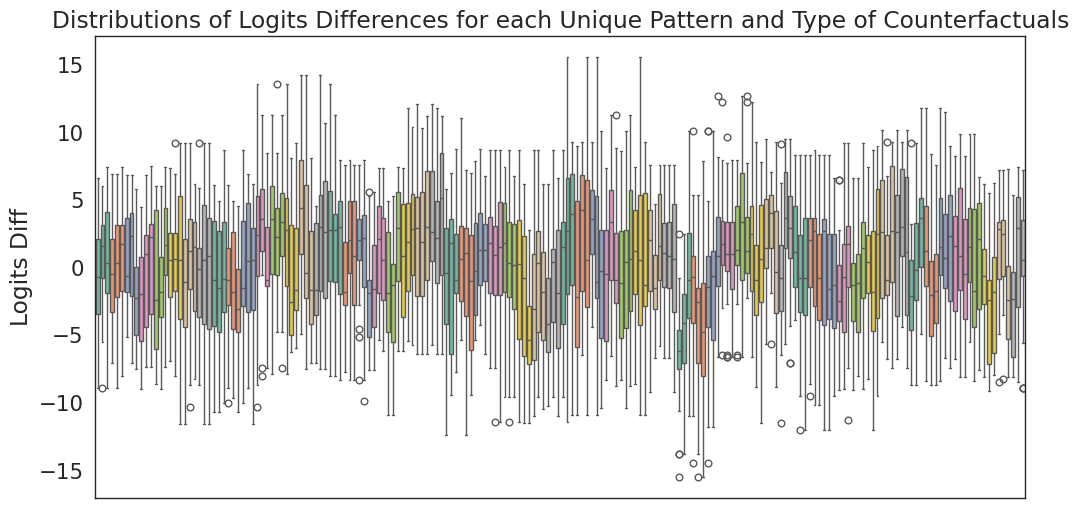

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

logits_tens = logit_diffs.reshape(3, -1, NUM_SAMPLES).cpu()
reshaped_tensor = logits_tens.view(3*len(patterns), NUM_SAMPLES)

logits_tens = logit_diffs.reshape(3, -1, NUM_SAMPLES).cpu()
reshaped_tensor = logits_tens.view(3*len(patterns), NUM_SAMPLES)

# Prepare the data for plotting
data = reshaped_tensor.numpy().T  # Transpose to have NUM_SAMPLES distributions of length 3*len(patterns)
df = pd.DataFrame(data)

df = df.melt(var_name='Group', value_name='Logits Diff')
df['Dim2'] = df['Group'] // 3

# Plotting
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Logits Diff', hue='Dim2', data=df, palette='Set2')

# Remove the legend
plt.legend([],[], frameon=False)


plt.xlabel('')
plt.xticks([])
plt.title('Distributions of Logits Differences for each Unique Pattern and Type of Counterfactuals')
plt.show()

In [ ]:
# Patterns are in some sense symmetric 
# if "synonym" behavior is all 0 - we only consider synonym pairs 
# if "synonym" behavior is all 1 - we only consider antonym pairs
# if "language" behavior is all 0 - we always remain within one language 
# if "language" behavior is all 1 - we always translate between languages
# it is interesting if synonym pairs vs antonym  pairs should be considered similar up to reflection
# or, similarly to language transorms, they relate as "identity" transform and "side-step" from the origin

pattern_sym_groups = np.sum(np.array(patterns), axis=-1)
pattern_sym_groups[pattern_sym_groups==2] = 0  # 2 and 0 are identical
pattern_sym_groups = [tuple(r) for r in pattern_sym_groups.tolist()]
unique_patterns = list(set(pattern_sym_groups))
pattern_colors = [unique_patterns.index(pat) for pat in  pattern_sym_groups]

In [ ]:
# we also want to match counterfactual types to the pattern in use
# for that we also need to keep track of the number of pairs (we use length=5) to index the pattern
# and decide which type of counterfactual is the most challenging for the model
# counterfactuals are ordered as "synonym, antonym, lang, antonym-lang" but we exclude one of them which is choses as a True Answer
# 

In [ ]:
df

,Group,Logits Diff,Dim2
0,0,4.244935,0
1,0,-0.750328,0
2,0,0.012775,0
3,0,0.001282,0
4,0,6.587385,0
...,...,...,...
5755,191,7.179964,63
5756,191,-0.100761,63
5757,191,4.964532,63
5758,191,-0.100761,63


In [ ]:
# df['Pattern_Type'].value_counts()

In [ ]:
import pandas as pd
import plotly.express as px

# Example tensors
NUM_SAMPLES = 30

logits_tens = logit_diffs.reshape(3, -1, NUM_SAMPLES).cpu()
reshaped_tensor = logits_tens.view(3*len(patterns), NUM_SAMPLES)

# Prepare the data for plotting
data = reshaped_tensor.numpy().T  # Transpose to have NUM_SAMPLES distributions of length 3*len(patterns)
df = pd.DataFrame(data)

# Melt the dataframe and create a column for Dim2 grouping by 3
df = df.melt(var_name='Group', value_name='Value')
df['Counterfactual_Type'] = np.tile((1,2,3), NUM_SAMPLES*len(pattern_colors))
df['Pattern_Type'] = np.repeat(3*pattern_colors, NUM_SAMPLES)
df['Pattern_Tuple'] = [unique_patterns[idx] for idx in df['Pattern_Type']]

df = df.sort_values(by='Pattern_Type')
df = df.rename(columns={'Value':'Logit Diff', 'Group':'Sentence Pattern'})
# Create the boxplot using plotly express
fig = px.box(df, x='Pattern_Type', y='Logit Diff', color='Counterfactual_Type', title='Boxplots Colored by Second Dimension', hover_data='Pattern_Tuple')


# Update layout to place the legend outside the plot
fig.update_layout(
    legend_title_text='Counterfactual Type',
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(255,255,255,0)'
    ),
    margin=dict(l=0, r=150, t=50, b=50),
    xaxis_title='Pattern Tuple',  # Update x-axis title
    xaxis_tickangle=-45  # Rotate x-axis ticks for better readability if needed
)

# Show the plot
fig.show()

In [ ]:
unique_patterns

[(1, 0, 1),
 (1, 1, 0),
 (0, 1, 0),
 (0, 0, 0),
 (1, 0, 0),
 (0, 0, 1),
 (1, 1, 1),
 (0, 1, 1)]

In [ ]:
# memory runs out when subsequent steps are executed on all patterns simultaneously 
# we select the most challenging patterns with the most oscillatory interactions

selected_patterns = [(0,0,0,), (0, 1, 0), (0, 0, 1), (1,1,1)]

indice_pattern_full = {}
indice_pattern_sym = {}
c = 0
for pat in patterns:
    for i in range(NUM_SAMPLES):
        c += 1
        tp = tuple(np.array(pat).sum(axis=1))
        if tp in selected_patterns:
            indice_pattern_full[c] = pat
            tp = [t if t!=2 else 0 for t in tp ]
            indice_pattern_sym[c] = tuple(tp)

selected_indices = np.array(list(indice_pattern_full))
indx_to_pat_type = [unique_patterns.index(s) for s in indice_pattern_sym.values()]

all_sele_logits = []
pattern_to_cache = {}
pattern_to_idx = {}
for unique_pat in set(indx_to_pat_type):
    sele = np.where(np.array(indx_to_pat_type)==unique_pat)[0]
    pattern_to_idx[unique_pat] = sele

    original_logits, cache = model.run_with_cache(tokens[selected_indices[sele]])
    pattern_to_cache[unique_pat] = cache
    all_sele_logits.append(original_logits)

all_sele_logits = torch.concat(all_sele_logits, dim=0)
selected_logits_diff = logits_to_ave_logit_diff(original_logits, all_answer_tokens[:,selected_indices].to(device), per_prompt=True)

In [ ]:
answer_residual_directions = model.tokens_to_residual_directions(all_answer_tokens[:,selected_indices])
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = (
    answer_residual_directions[0, None, :] - answer_residual_directions[1:, :]
)
logit_diff_directions = logit_diff_directions.mean(dim=0)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([4, 390, 768])
Logit difference directions shape: torch.Size([390, 768])


In [ ]:
for unique_pat in set(indx_to_pat_type):
    print(unique_pat, len(pattern_to_idx[unique_pat]))

2 60
3 30
5 60
6 240


In [ ]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type].
all_average_logit_diffs = {}
for unique_pat in set(indx_to_pat_type):
    sele = pattern_to_idx[unique_pat]
    cache = pattern_to_cache[unique_pat]
    final_residual_stream = cache["resid_post", -1]
    print("Final residual stream shape:", final_residual_stream.shape)
    final_token_residual_stream = final_residual_stream[:, -1, :]
    # Apply LayerNorm scaling
    # pos_slice is the subset of the positions we take - here the final token of each prompt
    scaled_final_token_residual_stream = cache.apply_ln_to_stack(
        final_token_residual_stream, layer=-1, pos_slice=-1
    )

    average_logit_diff = einsum(
        "batch d_model, batch d_model -> ",
        scaled_final_token_residual_stream,
        logit_diff_directions[sele,:],
    ) / len(indice_pattern_full)
    all_average_logit_diffs[unique_pat] = average_logit_diff
    print("Calculated average logit diff:", round(average_logit_diff.item(), 3))
    # print("Original logit difference:", round(original_average_logit_diff.item(), 3))

Final residual stream shape: torch.Size([60, 48, 768])
Calculated average logit diff: -0.117
Final residual stream shape: torch.Size([30, 48, 768])
Calculated average logit diff: 0.02
Final residual stream shape: torch.Size([60, 48, 768])
Calculated average logit diff: 0.282
Final residual stream shape: torch.Size([240, 48, 768])
Calculated average logit diff: 0.186


In [ ]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
    logit_diff_directions: torch.Tensor
    
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions,
    ) / len(indice_pattern_full)

In [ ]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensors, labels=None, **kwargs):
    # Check if tensors is a list of tensors
    if not isinstance(tensors, list):
        raise ValueError("tensors should be a list of tensors")

    # If no labels are provided, create default labels
    if labels is None:
        labels = [f"Line {i+1}" for i in range(len(tensors))]
    
    # Validate that the number of labels matches the number of tensors
    if len(labels) != len(tensors):
        raise ValueError("The number of labels must match the number of tensors")
    
    # Convert tensors to numpy arrays and create a dictionary for Plotly
    data = {
        'Value': [],
        'Index': [],
        'Label': []
    }
    
    for i, tensor in enumerate(tensors):
        tensor_np = np.squeeze(np.array(tensor.cpu()))
        if tensor_np.ndim != 1:
            raise ValueError(f"Tensor at index {i} is not 1D after squeezing")
        
        tensor_length = len(tensor_np)
        data['Value'].extend(tensor_np)
        data['Index'].extend(np.arange(tensor_length))
        data['Label'].extend([labels[i]] * tensor_length)
    
    # Create the line plot using Plotly Express
    fig = px.line(
        x=data['Index'],
        y=data['Value'],
        color=data['Label'],
        labels={"color": "Label"},
        **kwargs
    )
    
    # Show the plot
    fig.show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [ ]:
all_logit_lens_logit_diffs = []

for unique_pat in set(indx_to_pat_type):
    sele = pattern_to_idx[unique_pat]
    cache = pattern_to_cache[unique_pat]
    accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True,
                                                            pos_slice=-1, return_labels=True)
    logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache, logit_diff_directions[sele,:])
    all_logit_lens_logit_diffs.append(logit_lens_logit_diffs)

In [ ]:
[unique_patterns[unique_pat] for unique_pat in set(indx_to_pat_type)]

[(0, 1, 0), (0, 0, 0), (0, 0, 1), (1, 1, 1)]

In [ ]:
line(
    all_logit_lens_logit_diffs,
    labels= [unique_patterns[unique_pat] for unique_pat in set(indx_to_pat_type)],
    # x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    #hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream; Labels indicate Switching every second pair of (Connector, Language, Antonym)",
)

In [ ]:
set(indx_to_pat_type)

{2, 3, 5, 6}

In [ ]:
unique_patterns[6]

(1, 1, 1)

In [ ]:
per_head_logit_diffs_all = {}

for unique_pat in set(indx_to_pat_type):
    sele = pattern_to_idx[unique_pat]
    cache = pattern_to_cache[unique_pat]

    per_head_residual, labels = cache.stack_head_results(
        layer=-1, pos_slice=-1, return_labels=True
    )
    per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache, logit_diff_directions[sele,:])
    per_head_logit_diffs = einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    per_head_logit_diffs_all[unique_pat] = per_head_logit_diffs
    imshow(
        per_head_logit_diffs,
        labels={"x": "Head", "y": "Layer"},
        title="Logit Difference From Each Head",
    )

Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


In [ ]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [ ]:
pattern_to_cache.keys()

dict_keys([2, 3, 5, 6])

In [ ]:
top_k = 3

k = 6
l = 8
cache = pattern_to_cache[k]
sele = pattern_to_idx[k]
per_head_logit_diffs = per_head_logit_diffs_all[k]

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    cache,
    tokens[selected_indices[sele]][l],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    cache,
    tokens[selected_indices[sele]][l],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

print("".join(model.to_str_tokens(tokens[selected_indices[sele]][l])))
HTML(positive_html + negative_html)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>bon or vertueux, gagner and lose, activé or en marche, mâle and female, positif or affirmatif, droit and


In [ ]:
model.unembed.b_U.sum()

tensor(0., device='mps:0')

In [ ]:
k = 5
sele = pattern_to_idx[k]
sele_prompts = [all_prompts_flat[p] for p in selected_indices[sele]]
len(sele_prompts)

60

In [ ]:
corrupted_logits.shape

torch.Size([60, 48, 50257])

In [ ]:
answer_tokens[selected_indices[sele]].shape

torch.Size([60])

In [ ]:
answer_tokens[selected_indices[sele]]

tensor([   69,  2364,   525, 36460,  7617, 36460,    85,    75, 13159, 49075,
         2302, 43435, 12093,  2364,    82, 28920, 21378,    82,    85, 36460,
         7617, 21953,   525, 43435,    79,    82,    82,    75,    77, 29370,
         1851,  2001, 11664,   805, 44070, 33106,  2787, 29370,  3876, 33106,
         1671,  2001,  1671, 29199, 26452,  2001,   634, 30283,    67,    83,
         1671, 11664,    69,   259, 30283,   259,    69,  9464,  3262, 32165],
       device='mps:0')

In [ ]:
corrupted_prompts = []
for i in range(len(sele_prompts)):
    pr = sele_prompts[i]
    pr = pr.rstrip('or')
    pr += 'and'
    corrupted_prompts.append(pr)

    
corrupted_tokens = model.to_tokens(corrupted_prompts, prepend_bos=True)
corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(all_average_logit_diffs[k].item(), 2))

Corrupted Average Logit Diff -0.5
Clean Average Logit Diff 0.28


In [ ]:
sele_prompts[:3]

['commencer or débuter, haut or bas, bon or vertueux, grand or petit, droit or correct, vrai or',
 'hot or warm, left or right, alive or living, yes or no, inside or inward, on or',
 'haut or au-dessus, allumé or éteint, plein or rempli, intérieur or extérieur, ouvert or déverrouillé, gagner or']

In [ ]:
corrupted_prompts[:3]

['ouvert or déverrouillé, gauche or droite, heureux or joyeux, riche or pauvre, gagner or réussir, vrai and',
 'light or bright, male or female, true or correct, full or empty, present or here, hot and',
 'jour or journée, ouvert or fermé, intérieur or dedans, oui or non, haut or au-dessus, propre and']

In [ ]:
original_average_logit_diff = all_average_logit_diffs[k]

In [ ]:
corrupted_tokens.shape

torch.Size([60, 48])

In [ ]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    # print(corrupted_residual_component.shape)
    # print(clean_cache[hook.name].shape)
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component


def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_average_logit_diff) / (
        original_average_logit_diff - corrupted_average_logit_diff
    )

k = 5
sele = pattern_to_idx[k]
tokks = tokens[selected_indices[sele]]

cache = pattern_to_cache[k]
patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, tokks.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(tokks.shape[1]):
        try:
            hook_fn = partial(patch_residual_component, pos=position, clean_cache=cache)
            patched_logits = model.run_with_hooks(
                corrupted_tokens,
                fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
                return_type="logits",
            )
            patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

            patched_residual_stream_diff[layer, position] = normalize_patched_logit_diff(
                patched_logit_diff
            )
        except:
            pass

In [ ]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(tokks[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

In [ ]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

        patched_head_z_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [ ]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
)

In [ ]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("v", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

        patched_head_v_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [ ]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [ ]:
def patch_head_pattern(
    corrupted_head_pattern: Float[torch.Tensor, "batch head_index query_pos d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_pattern[:, head_index, :, :] = clean_cache[hook.name][
        :, head_index, :, :
    ]
    return corrupted_head_pattern


patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens[selected_indices[sele]].unsqueeze(1))

        patched_head_attn_diff[layer, head_index] = normalize_patched_logit_diff(
            patched_logit_diff
        )

In [ ]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)